# 題目：使用神經網絡從細胞來判斷是否有瘧疾
## 組員：黃世漳 B03613041  陳永強 B03201056
## 簡單介紹：

* 瘧疾是一種致命性的寄生蟲傳染病
* Plasmodium falciparum 會透過瘧蚊寄生在人類身上，而它的生命週期的其中一環就是寄生在人類的紅血球上
* 檢驗方式就是透過染劑觀察紅血球有沒有Plasmodium falciparum
* **輸入**：細胞圖片  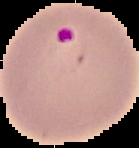 Parasitized(有病）
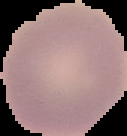 Uninfected(沒病）  
**輸出**：有無瘧疾，有為1，無為0
* 使用了CNN來判斷該細胞是否有瘧疾

## 實際應用
或許很多人不知道，不過類似的機器目前已經投入我們日常的醫學檢驗工作當中了。因其中的組員黃世漳是醫技系的學生，有幸可以參觀台大醫院的醫檢部，也有幸跟學長姐了解到內部  
台大醫院的機器已經可以自動辨識紅血球的好壞，自動做各種檢驗，只有少數的檢驗是需要人工的全程參與  
即使在3年前是需要人類的全程參與也不代表現台大醫院醫檢部還是需要人工檢驗畢竟很多時候那個科技是已經存在了，只是台大醫院還沒有購入相關機器而已


## 資料庫:
* [Source](https://www.kaggle.com/iarunava/cell-images-for-detecting-malaria?fbclid=IwAR1m-jzGwGi9FtR7KtnD7LG_FNDaEXWA-XVLIt2XwIGdaqoqEpdNF7s5J-c)
* 一共有27560份資料，有瘧疾的照片和沒有瘧疾的照片各佔一半

## 心得&結論
* Normalizing很重要，如果沒有normalize，準確度只會停留在50%左右
* 我們發現我們倆的電腦計算資源遠遠不夠，因此想辦法在Google Colab運行
* 即使我們把圖片設成 150*150 我們還是無法載入所有的圖片去做訓練，因為Google Colab的12gb Ram會不夠
* 最後發現即使我們把圖片縮小到 100*100 後，依然沒有影響model的準確度，所有的model的準確度都在96%左右
* 在其他參數都保持一樣的情況下，5次convolution & max pooling或者3次convolution & max pooling對準確度沒有太大的影響
* 乍看之下好像很容易可以分辨Parasitized（患病）和Uninfected（沒病），不過如果我們參考回model都會犯錯的照片發現原來真的不簡單。 因為很多時候是染劑染得不好：把沒有染病的細胞染上染劑，讓我們倆的肉眼也會誤判是Parasitized；另外，Parasitized的細胞卻沒有染上染劑，令到我們的模型誤判為Uninfected，但專業人員還是可以看得出來是Parasitized的細胞

## Step 1:  使用Kaggle API直接從Kaggle載入Malaria資料
由於一共有2萬張照片，在每次跑都要跑好幾個小時的情況下，我們只好使用Google Colab提供的免費12gb Ram。

In [0]:
!pip install -q kaggle

In [0]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

In [0]:
! chmod 600 ~/.kaggle/kaggle.json

In [4]:
 ! kaggle datasets list

ref                                                    title                                          size  lastUpdated          downloadCount  
-----------------------------------------------------  --------------------------------------------  -----  -------------------  -------------  
vjchoudhary7/customer-segmentation-tutorial-in-python  Mall Customer Segmentation Data                 2KB  2018-08-11 07:23:02          17160  
russellyates88/suicide-rates-overview-1985-to-2016     Suicide Rates Overview 1985 to 2016           396KB  2018-12-01 19:18:25          41891  
iarunava/cell-images-for-detecting-malaria             Malaria Cell Images Dataset                   337MB  2018-12-05 05:40:21           9575  
bigquery/crypto-ethereum-classic                       Ethereum Classic Blockchain                    70GB  2019-03-20 23:21:25              0  
jessicali9530/stanford-dogs-dataset                    Stanford Dogs Dataset                         735MB  2019-02-13 05:45:25   

In [5]:
!kaggle datasets download -d iarunava/cell-images-for-detecting-malaria

 96% 325M/337M [00:03<00:00, 109MB/s] 
100% 337M/337M [00:03<00:00, 89.9MB/s]


In [0]:
!unzip \*.zip 

##Step 2: 資料整理

In [3]:
%env KERAS_BACKEND=tensorflow
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
#from ipywidgets import interact_manual
import os
import cv2
import sys
import scipy
import tensorflow as tf
import random

env: KERAS_BACKEND=tensorflow


In [4]:
from tqdm import tqdm
from IPython.display import SVG
from sklearn.model_selection import train_test_split
from keras.datasets import mnist
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.layers import Dense, Conv2D,MaxPool2D, MaxPooling2D,Dropout,BatchNormalization,Flatten
from keras.optimizers import SGD
from keras.models import Model
from keras.layers import Input
from keras.layers import concatenate, add
from keras import Sequential
from keras.preprocessing import image
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model


Using TensorFlow backend.


In [0]:
Directory= r"cell_images"
Categories=["Parasitized","Uninfected"]

###變數解析  
path_p: 患病的資料所在地  
list_of_img_name_p: 所有患病的檔案/照片名字  
path_u: 健康的資料所在地  
list_of_img_name_u: 所有健康的檔案/照片名字  

In [0]:
path_p=os.path.join(Directory, "Parasitized")
list_of_img_name_p=os.listdir(path_p)
path_u=os.path.join(Directory, "Uninfected")
list_of_img_name_u=os.listdir(path_u)
path_p=os.path.join(Directory, "Parasitized")
list_of_img_name_p=os.listdir(path_p)
path_u=os.path.join(Directory, "Uninfected")
list_of_img_name_u=os.listdir(path_u)

In [7]:
len(list_of_img_name_p) 

13780

In [8]:
len(list_of_img_name_u)

13780

以下是要把所有的照片變成array，而且要把所有的Image_array變成CNN可以接受的dimension. i.e. (筆數，img_size, img_size, 顏色)

In [9]:
img_array=[]  #Initialise img_array
img_size=100 #Image的大小設為100*100
size=len(list_of_img_name_u)
for ic in range(size):
  try:
    img=image.load_img(path_p+"/"+list_of_img_name_p[ic],target_size=(img_size,img_size))
    temp=image.img_to_array(img)
    img_array.append(temp)
  except:
    print(list_of_img_name_p[ic]+" can't be added") 
    #Data裡有Thumbs.db這種無法被視為是image的noise在，因此我們只好使用try, except

for ic in range(size):
  try:
    img =image.load_img(path_u+"/"+list_of_img_name_u[ic],target_size=(img_size,img_size))
    temp=image.img_to_array(img)
    img_array.append(temp)
  except:
    print(list_of_img_name_u[ic]+" can't be added")

img_array = np.array(img_array)  #把img_array轉換成array

Thumbs.db can't be added
Thumbs.db can't be added


目前一共有 $2*13780-2=27558$ 張$100*100$的照片

In [10]:
size=int(np.shape(img_array)[0])
np.shape(img_array)

(27558, 100, 100, 3)

我們把Parasitized=1; Uninfected=0

In [11]:
Y=np.hstack((np.ones(int(np.shape(img_array)[0]/2)),np.zeros(int(np.shape(img_array)[0]/2))))
Y.shape

(27558,)

In [0]:
x_train, x_test, y_train, y_test = train_test_split(img_array, Y, test_size=0.2, random_state = 66)

**如果沒有normalize，在訓練的時候不會有任何的進步！**

In [0]:
x_train = x_train/255
x_test = x_test/255

In [0]:
y_train = np_utils.to_categorical(y_train, 2)
y_test = np_utils.to_categorical(y_test, 2)

##Step 3i: 模型建立 model

In [15]:
model = Sequential()

model.add(Conv2D(8, (5, 5), padding='same', input_shape=(img_size, img_size, 3)))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2)))
#第一次Convolution跟Max-Pooling

model.add(Conv2D(16, (5, 5), padding='same', input_shape=(img_size, img_size, 3)))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2)))
#第二次Convolution跟Max-Pooling

model.add(Conv2D(32, (5, 5), padding='same', input_shape=(img_size, img_size, 3)))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2)))
#第三次Convolution跟Max-Pooling

model.add(Flatten())  #用來拉平用的，拉平後才能送入一般的神經網路
model.add(Dense(16))
model.add(Activation('relu'))
#一般的神經網路

model.add(Dense(2))
model.add(Activation(tf.nn.softmax))
#輸出層

model.compile(loss='mse', optimizer=SGD(lr=0.05), metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.


In [16]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 100, 100, 8)       608       
_________________________________________________________________
activation_1 (Activation)    (None, 100, 100, 8)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 50, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 50, 16)        3216      
_________________________________________________________________
activation_2 (Activation)    (None, 50, 50, 16)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 25, 25, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 25, 25, 32)        12832     
__________

In [17]:
model.fit(x_train, y_train, batch_size=40, epochs=15)

Instructions for updating:
Use tf.cast instead.
Epoch 1/15
22046/22046 [==============================] - 11s 493us/step - loss: 0.2408 - acc: 0.5757
Epoch 2/15
22046/22046 [==============================] - 5s 230us/step - loss: 0.1899 - acc: 0.7066
Epoch 3/15
22046/22046 [==============================] - 5s 231us/step - loss: 0.0561 - acc: 0.9315
Epoch 4/15
22046/22046 [==============================] - 5s 230us/step - loss: 0.0400 - acc: 0.9514
Epoch 5/15
22046/22046 [==============================] - 5s 230us/step - loss: 0.0366 - acc: 0.9555
Epoch 6/15
22046/22046 [==============================] - 5s 231us/step - loss: 0.0355 - acc: 0.9564
Epoch 7/15
22046/22046 [==============================] - 5s 231us/step - loss: 0.0337 - acc: 0.9585
Epoch 8/15
22046/22046 [==============================] - 5s 231us/step - loss: 0.0327 - acc: 0.9604
Epoch 9/15
22046/22046 [==============================] - 5s 234us/step - loss: 0.0327 - acc: 0.9599
Epoch 10/15
22046/22046 [=================

##Step 4i: 模型檢討 model



In [18]:
score = model.evaluate(x_test, y_test)
print("Loss: %f" %score[0])
print("準確率: %f" %(score[1]*100))

5512/5512 [==============================] - 1s 214us/step
Loss: 0.030664
準確率: 96.226415


###變數解析  
predict_0: 模型1做出來的答案  
w_0: 模型1判斷錯誤的照片index

In [32]:
predict_0 = model.predict_classes(x_test)
w_0=[]
for ic in range(np.shape(y_test)[0]):
  if (predict_0[ic] == 1) & (y_test[ic][1]==0) :
     w_0.append(ic)
  if (predict_0[ic] == 0) & (y_test[ic][0]==0) :
     w_0.append(ic)
w_0

[0,
 42,
 92,
 98,
 148,
 150,
 235,
 312,
 321,
 395,
 417,
 433,
 474,
 517,
 553,
 609,
 616,
 618,
 619,
 643,
 674,
 722,
 752,
 756,
 770,
 778,
 813,
 827,
 830,
 848,
 902,
 933,
 941,
 956,
 967,
 992,
 1010,
 1047,
 1054,
 1163,
 1194,
 1239,
 1248,
 1270,
 1289,
 1344,
 1488,
 1517,
 1554,
 1564,
 1577,
 1586,
 1623,
 1662,
 1672,
 1720,
 1751,
 1782,
 1806,
 1814,
 1819,
 1881,
 1884,
 1885,
 1887,
 1946,
 1968,
 1979,
 1987,
 1991,
 2011,
 2084,
 2089,
 2115,
 2129,
 2174,
 2188,
 2208,
 2242,
 2333,
 2385,
 2394,
 2457,
 2475,
 2479,
 2481,
 2523,
 2541,
 2564,
 2579,
 2589,
 2618,
 2622,
 2629,
 2691,
 2707,
 2713,
 2717,
 2721,
 2726,
 2791,
 2794,
 2809,
 2842,
 2869,
 2893,
 2956,
 2968,
 3013,
 3030,
 3041,
 3045,
 3092,
 3120,
 3127,
 3138,
 3145,
 3150,
 3177,
 3188,
 3261,
 3264,
 3296,
 3315,
 3338,
 3340,
 3390,
 3417,
 3442,
 3470,
 3479,
 3526,
 3527,
 3561,
 3581,
 3586,
 3600,
 3601,
 3602,
 3622,
 3631,
 3677,
 3700,
 3736,
 3740,
 3751,
 3815,
 3866,
 3901

一共有216/5512張照片判讀錯誤

In [84]:
len(w_0)

216

###函數解析
test_0吃入model判斷錯誤的照片的index，然後test回傳model誤判為什麼

In [0]:
def test_0(ic):
    if predict_0[ic] == 1:
       return 'Model determined as Parasitized'
    else:
       return 'Model determined as Uninfected'

隨機的9張判斷錯誤的照片

###到底model判斷錯誤了什麼？？

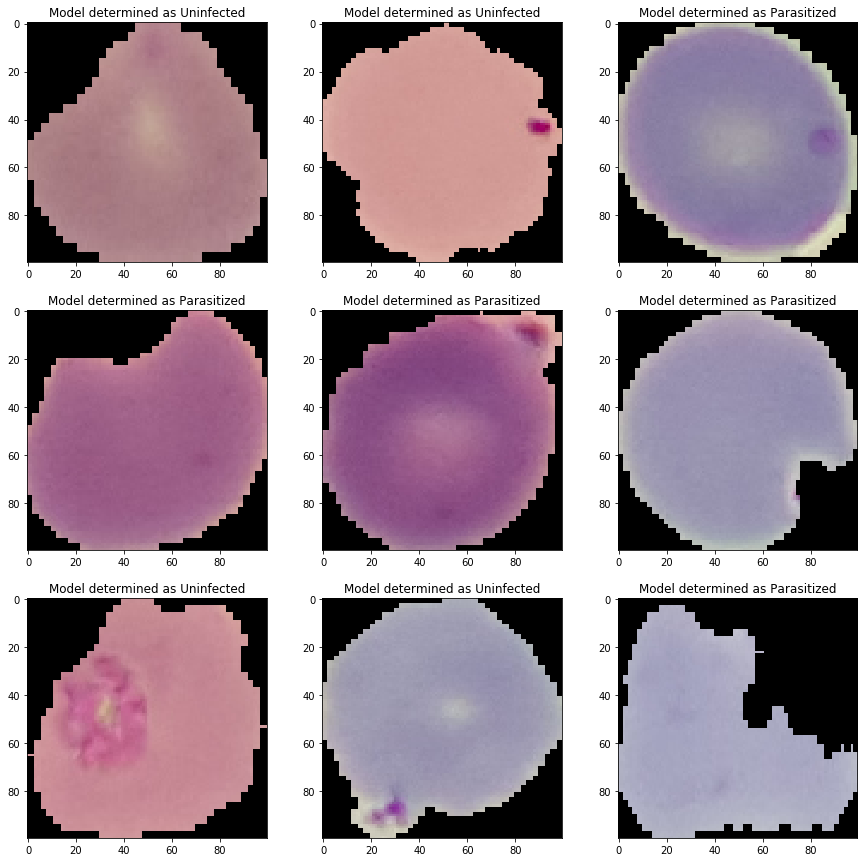

In [34]:
random_number=random.randrange(0,len(w_0))
fig, axs=plt.subplots(3,3,figsize=(15,15))
random.seed(random_number)
axs[0,0].imshow(x_test[w_0[random.randrange(0,len(w_0))]]);
axs[0,0].set_title(test_0(w_0[random.randrange(0,len(w_0))]));
random.seed(450+random_number)
axs[0,1].imshow(x_test[w_0[random.randrange(0,len(w_0))]]);
axs[0,1].set_title(test_0(w_0[random.randrange(0,len(w_0))]));
random.seed(550+random_number)
axs[0,2].imshow(x_test[w_0[random.randrange(0,len(w_0))]]);
axs[0,2].set_title(test_0(w_0[random.randrange(0,len(w_0))]));
random.seed(650+random_number)
axs[1,0].imshow(x_test[w_0[random.randrange(0,len(w_0))]]);
axs[1,0].set_title(test_0(w_0[random.randrange(0,len(w_0))]));
random.seed(750+random_number)
axs[1,1].imshow(x_test[w_0[random.randrange(0,len(w_0))]]);
axs[1,1].set_title(test_0(w_0[random.randrange(0,len(w_0))]));
random.seed(850+random_number)
axs[1,2].imshow(x_test[w_0[random.randrange(0,len(w_0))]]);
axs[1,2].set_title(test_0(w_0[random.randrange(0,len(w_0))]));
random.seed(80+random_number)
axs[2,0].imshow(x_test[w_0[random.randrange(0,len(w_0))]]);
axs[2,0].set_title(test_0(w_0[random.randrange(0,len(w_0))]));
random.seed(90+random_number)
axs[2,1].imshow(x_test[w_0[random.randrange(0,len(w_0))]]);
axs[2,1].set_title(test_0(w_0[random.randrange(0,len(w_0))]));
random.seed(100+random_number)
axs[2,2].imshow(x_test[w_0[random.randrange(0,len(w_0))]]);
axs[2,2].set_title(test_0(w_0[random.randrange(0,len(w_0))]));

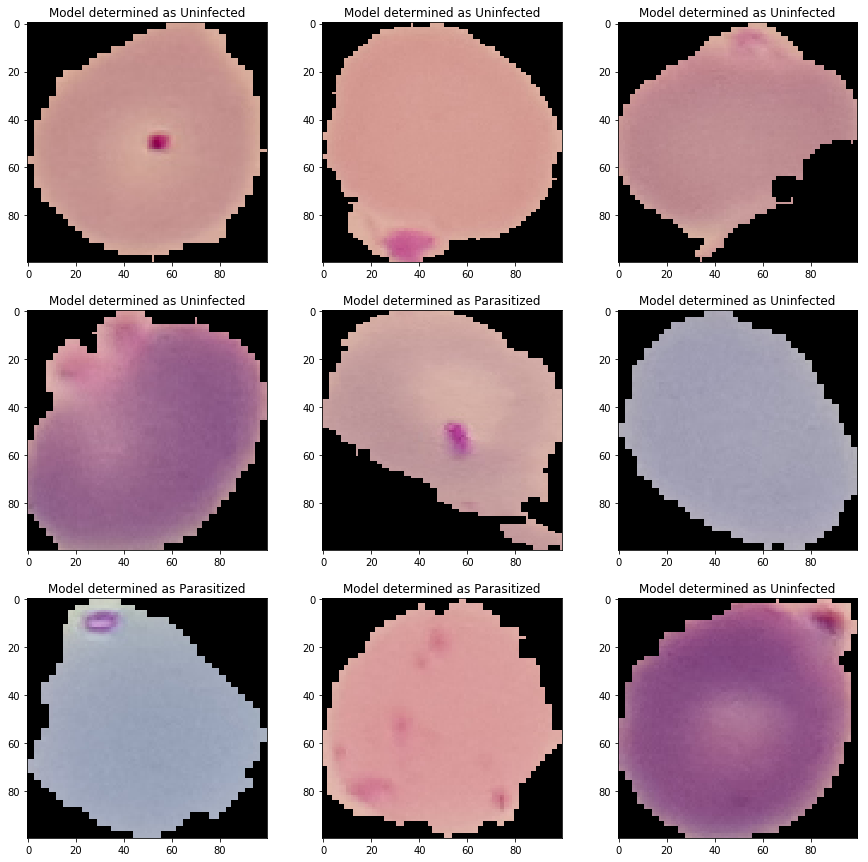

In [35]:
random_number=random.randrange(0,len(w_0))
fig, axs=plt.subplots(3,3,figsize=(15,15))
random.seed(random_number)
axs[0,0].imshow(x_test[w_0[random.randrange(0,len(w_0))]]);
axs[0,0].set_title(test_0(w_0[random.randrange(0,len(w_0))]));
random.seed(450+random_number)
axs[0,1].imshow(x_test[w_0[random.randrange(0,len(w_0))]]);
axs[0,1].set_title(test_0(w_0[random.randrange(0,len(w_0))]));
random.seed(550+random_number)
axs[0,2].imshow(x_test[w_0[random.randrange(0,len(w_0))]]);
axs[0,2].set_title(test_0(w_0[random.randrange(0,len(w_0))]));
random.seed(650+random_number)
axs[1,0].imshow(x_test[w_0[random.randrange(0,len(w_0))]]);
axs[1,0].set_title(test_0(w_0[random.randrange(0,len(w_0))]));
random.seed(750+random_number)
axs[1,1].imshow(x_test[w_0[random.randrange(0,len(w_0))]]);
axs[1,1].set_title(test_0(w_0[random.randrange(0,len(w_0))]));
random.seed(850+random_number)
axs[1,2].imshow(x_test[w_0[random.randrange(0,len(w_0))]]);
axs[1,2].set_title(test_0(w_0[random.randrange(0,len(w_0))]));
random.seed(80+random_number)
axs[2,0].imshow(x_test[w_0[random.randrange(0,len(w_0))]]);
axs[2,0].set_title(test_0(w_0[random.randrange(0,len(w_0))]));
random.seed(90+random_number)
axs[2,1].imshow(x_test[w_0[random.randrange(0,len(w_0))]]);
axs[2,1].set_title(test_0(w_0[random.randrange(0,len(w_0))]));
random.seed(100+random_number)
axs[2,2].imshow(x_test[w_0[random.randrange(0,len(w_0))]]);
axs[2,2].set_title(test_0(w_0[random.randrange(0,len(w_0))]));

##Step 3ii: 模型建立 model_2

In [0]:
model_2 = Sequential()

model_2.add(Conv2D(8, (5, 5), padding='same', input_shape=(img_size, img_size, 3)))
model_2.add(Activation('relu'))
model_2.add(MaxPool2D(pool_size=(2,2)))
#第一次Convolution跟Max-Pooling

model_2.add(Conv2D(16, (5, 5), padding='same', input_shape=(img_size, img_size, 3)))
model_2.add(Activation('relu'))
model_2.add(MaxPool2D(pool_size=(2,2)))
#第二次Convolution跟Max-Pooling

model_2.add(Conv2D(32, (5, 5), padding='same', input_shape=(img_size, img_size, 3)))
model_2.add(Activation('relu'))
model_2.add(MaxPool2D(pool_size=(2,2)))
#第三次Convolution跟Max-Pooling

model_2.add(Conv2D(64, (5, 5), padding='same', input_shape=(img_size, img_size, 3)))
model_2.add(Activation('relu'))
model_2.add(MaxPool2D(pool_size=(2,2)))
#第四次Convolution跟Max-Pooling

model_2.add(Conv2D(128, (5, 5), padding='same', input_shape=(img_size, img_size, 3)))
model_2.add(Activation('relu'))
model_2.add(MaxPool2D(pool_size=(2,2)))
#第五次Convolution跟Max-Pooling


model_2.add(Flatten())  #用來拉平用的，拉平後才能送入一般的神經網路
model_2.add(Dense(16))
model_2.add(Activation('relu'))
#一般的神經網路

model_2.add(Dense(2))
model_2.add(Activation(tf.nn.softmax))
#輸出層

model_2.compile(loss='mse', optimizer=SGD(lr=0.05), metrics=['accuracy'])

In [110]:
model_2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 100, 100, 8)       608       
_________________________________________________________________
activation_6 (Activation)    (None, 100, 100, 8)       0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 50, 50, 8)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 50, 50, 16)        3216      
_________________________________________________________________
activation_7 (Activation)    (None, 50, 50, 16)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 25, 25, 16)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 25, 25, 32)        12832     
__________

In [37]:
model_2.fit(x_train, y_train, batch_size=40, epochs=15)

Epoch 1/15
22046/22046 [==============================] - 6s 294us/step - loss: 0.2498 - acc: 0.5218
Epoch 2/15
22046/22046 [==============================] - 6s 273us/step - loss: 0.2477 - acc: 0.5448
Epoch 3/15
22046/22046 [==============================] - 6s 275us/step - loss: 0.2300 - acc: 0.6192
Epoch 4/15
22046/22046 [==============================] - 6s 276us/step - loss: 0.0862 - acc: 0.8871
Epoch 5/15
22046/22046 [==============================] - 6s 275us/step - loss: 0.0395 - acc: 0.9522
Epoch 6/15
22046/22046 [==============================] - 6s 276us/step - loss: 0.0361 - acc: 0.9558
Epoch 7/15
22046/22046 [==============================] - 6s 274us/step - loss: 0.0341 - acc: 0.9592
Epoch 8/15
22046/22046 [==============================] - 6s 273us/step - loss: 0.0333 - acc: 0.9596
Epoch 9/15
22046/22046 [==============================] - 6s 276us/step - loss: 0.0324 - acc: 0.9612
Epoch 10/15
22046/22046 [==============================] - 6s 276us/step - loss: 0.0318 - a

##Step 4ii: 模型檢討 model_2

In [38]:
score = model_2.evaluate(x_test, y_test)
print("Loss: %f" %score[0])
print("準確率: %f" %(score[1]*100))

5512/5512 [==============================] - 1s 178us/step
Loss: 0.030364
準確率: 96.371553


In [0]:
predict_2 = model_2.predict_classes(x_test)

In [40]:
predict_2 = model_2.predict_classes(x_test)
w_2=[]
for ic in range(np.shape(y_test)[0]):
  if (predict_2[ic] == 1) & (y_test[ic][1]==0) :
     w_2.append(ic)
  if (predict_2[ic] == 0) & (y_test[ic][0]==0) :
     w_2.append(ic)
w_2
      

[0,
 42,
 92,
 98,
 148,
 171,
 182,
 235,
 293,
 321,
 395,
 417,
 474,
 517,
 553,
 609,
 616,
 618,
 619,
 643,
 674,
 722,
 752,
 756,
 813,
 827,
 830,
 848,
 902,
 933,
 941,
 956,
 979,
 992,
 1010,
 1054,
 1163,
 1194,
 1248,
 1270,
 1289,
 1488,
 1554,
 1564,
 1577,
 1586,
 1623,
 1637,
 1662,
 1672,
 1751,
 1782,
 1791,
 1806,
 1814,
 1837,
 1884,
 1885,
 1887,
 1946,
 1968,
 1979,
 1987,
 1991,
 2011,
 2084,
 2089,
 2115,
 2129,
 2174,
 2208,
 2242,
 2317,
 2333,
 2385,
 2394,
 2457,
 2479,
 2481,
 2523,
 2541,
 2564,
 2579,
 2589,
 2629,
 2691,
 2707,
 2713,
 2717,
 2721,
 2726,
 2791,
 2794,
 2809,
 2842,
 2865,
 2896,
 2956,
 2968,
 3013,
 3041,
 3045,
 3092,
 3095,
 3120,
 3124,
 3127,
 3138,
 3145,
 3150,
 3177,
 3188,
 3236,
 3261,
 3296,
 3315,
 3324,
 3338,
 3340,
 3390,
 3417,
 3442,
 3470,
 3479,
 3526,
 3527,
 3561,
 3581,
 3586,
 3601,
 3602,
 3622,
 3631,
 3677,
 3700,
 3736,
 3740,
 3751,
 3815,
 3866,
 3901,
 3927,
 3945,
 3989,
 4012,
 4023,
 4044,
 4047,
 40

In [0]:
def test_2(ic):
    if predict_2[ic] == 1:
       return 'Model_2 determined as Parasitized'
    else:
       return 'Model_2 determined as Uninfected'

###到底model_2判斷錯誤了什麼？？

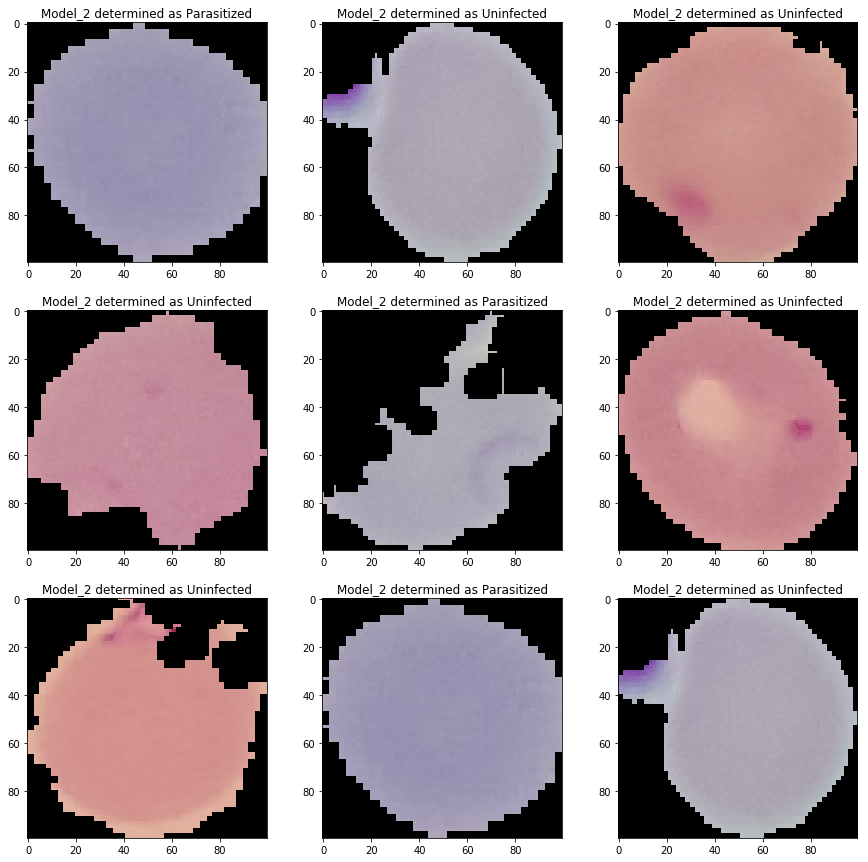

In [64]:
random_number=random.randrange(0,len(w_2))
fig, axs=plt.subplots(3,3,figsize=(15,15))
for ic in range(3):
  for icj in range(3):
    random.seed(random_number+2*icj-ic)
    axs[ic,icj].imshow(x_test[w_2[random.randrange(0,len(w_2))]]);
    axs[ic,icj].set_title(test_2(w_2[random.randrange(0,len(w_2))]));

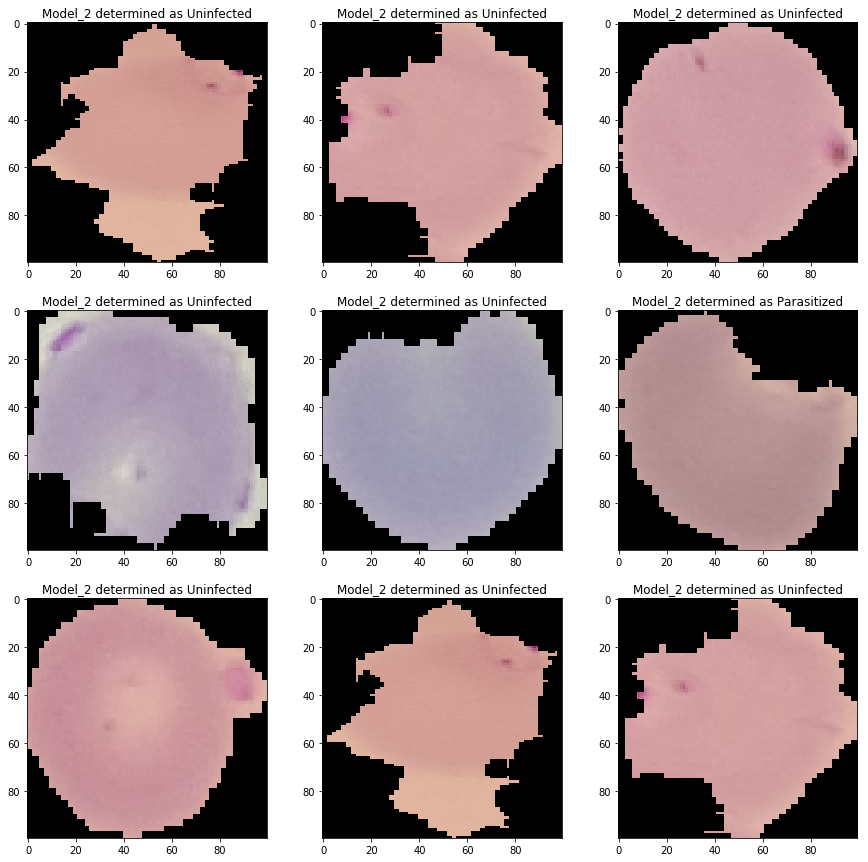

In [63]:
random_number=random.randrange(0,len(w_0))
fig, axs=plt.subplots(3,3,figsize=(15,15))
for ic in range(3):
  for icj in range(3):
    random.seed(random_number+2*icj-ic)
    axs[ic,icj].imshow(x_test[w_2[random.randrange(0,len(w_2))]]);
    axs[ic,icj].set_title(test_2(w_2[random.randrange(0,len(w_2))]));

##Step 3iii: 模型建立 model_3

In [0]:
filter_size=8

model_3 = Sequential()

model_3.add(Conv2D(8, (filter_size, filter_size), padding='same', input_shape=(img_size, img_size, 3)))
model_3.add(Activation('relu'))
model_3.add(MaxPool2D(pool_size=(2,2)))
#第一次Convolution跟Max-Pooling

model_3.add(Conv2D(16, (filter_size, filter_size), padding='same', input_shape=(img_size, img_size, 3)))
model_3.add(Activation('relu'))
model_3.add(MaxPool2D(pool_size=(2,2)))
#第二次Convolution跟Max-Pooling

model_3.add(Conv2D(32, (filter_size, filter_size), padding='same', input_shape=(img_size, img_size, 3)))
model_3.add(Activation('relu'))
model_3.add(MaxPool2D(pool_size=(2,2)))
#第三次Convolution跟Max-Pooling

model_3.add(Conv2D(64, (filter_size, filter_size), padding='same', input_shape=(img_size, img_size, 3)))
model_3.add(Activation('relu'))
model_3.add(MaxPool2D(pool_size=(2,2)))
#第四次Convolution跟Max-Pooling

model_3.add(Flatten())  #用來拉平用的，拉平後才能送入一般的神經網路
model_3.add(Dense(64))
model_3.add(Activation('relu'))
#一般的神經網路

model_3.add(Dense(2))
model_3.add(Activation(tf.nn.softmax))
#輸出層

model_3.compile(loss='mse', optimizer=SGD(lr=0.05), metrics=['accuracy'])

In [137]:
model_3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 100, 100, 8)       1544      
_________________________________________________________________
activation_19 (Activation)   (None, 100, 100, 8)       0         
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 50, 50, 8)         0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 50, 50, 16)        8208      
_________________________________________________________________
activation_20 (Activation)   (None, 50, 50, 16)        0         
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 25, 25, 16)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 25, 25, 32)        32800     
__________

In [46]:
model_3.fit(x_train, y_train, batch_size=40, epochs=15)

Epoch 1/15
22046/22046 [==============================] - 7s 327us/step - loss: 0.2411 - acc: 0.5728
Epoch 2/15
22046/22046 [==============================] - 7s 303us/step - loss: 0.1029 - acc: 0.8562
Epoch 3/15
22046/22046 [==============================] - 7s 304us/step - loss: 0.0439 - acc: 0.9463
Epoch 4/15
22046/22046 [==============================] - 7s 304us/step - loss: 0.0376 - acc: 0.9546
Epoch 5/15
22046/22046 [==============================] - 7s 304us/step - loss: 0.0359 - acc: 0.9565
Epoch 6/15
22046/22046 [==============================] - 7s 305us/step - loss: 0.0338 - acc: 0.9591
Epoch 7/15
22046/22046 [==============================] - 7s 302us/step - loss: 0.0331 - acc: 0.9597
Epoch 8/15
22046/22046 [==============================] - 7s 302us/step - loss: 0.0322 - acc: 0.9610
Epoch 9/15
22046/22046 [==============================] - 7s 305us/step - loss: 0.0312 - acc: 0.9627
Epoch 10/15
22046/22046 [==============================] - 7s 308us/step - loss: 0.0305 - a

##Step4iii: 模型檢討 model_3

In [47]:
score = model_3.evaluate(x_test, y_test)
print("Loss: %f" %score[0])
print("準確率: %f" %(score[1]*100))

5512/5512 [==============================] - 1s 182us/step
Loss: 0.030577
準確率: 96.280842


In [48]:
predict_3 = model_3.predict_classes(x_test)
w_3=[]
for ic in range(np.shape(y_test)[0]):
  if (predict_3[ic] == 1) & (y_test[ic][1]==0) :
     w_3.append(ic)
  if (predict_3[ic] == 0) & (y_test[ic][0]==0) :
     w_3.append(ic)
w_3

[0,
 42,
 92,
 98,
 111,
 148,
 172,
 182,
 235,
 293,
 321,
 395,
 474,
 517,
 553,
 609,
 616,
 618,
 643,
 674,
 722,
 752,
 756,
 813,
 827,
 830,
 848,
 902,
 933,
 941,
 956,
 979,
 991,
 992,
 1010,
 1047,
 1054,
 1163,
 1194,
 1248,
 1270,
 1289,
 1488,
 1526,
 1554,
 1564,
 1577,
 1586,
 1623,
 1662,
 1672,
 1679,
 1742,
 1751,
 1782,
 1806,
 1814,
 1837,
 1861,
 1881,
 1884,
 1885,
 1887,
 1946,
 1968,
 1979,
 1987,
 1991,
 2011,
 2084,
 2089,
 2115,
 2129,
 2174,
 2208,
 2238,
 2242,
 2333,
 2385,
 2394,
 2457,
 2475,
 2479,
 2481,
 2523,
 2541,
 2564,
 2579,
 2589,
 2629,
 2707,
 2713,
 2717,
 2721,
 2726,
 2791,
 2794,
 2809,
 2842,
 2865,
 2893,
 2896,
 2956,
 3013,
 3030,
 3041,
 3045,
 3092,
 3095,
 3120,
 3124,
 3138,
 3150,
 3177,
 3188,
 3236,
 3261,
 3296,
 3315,
 3324,
 3338,
 3340,
 3390,
 3417,
 3442,
 3470,
 3526,
 3527,
 3561,
 3579,
 3581,
 3586,
 3601,
 3602,
 3631,
 3659,
 3677,
 3736,
 3740,
 3751,
 3815,
 3843,
 3866,
 3901,
 3927,
 3945,
 3989,
 4012,
 40

###到底model_3判斷錯誤了什麼？？

In [0]:
def test_3(ic):

    if predict_3[ic] == 1:
       return 'Model_3 determined as Parasitized'
    else:
       return 'Model_3 determined as Uninfected'

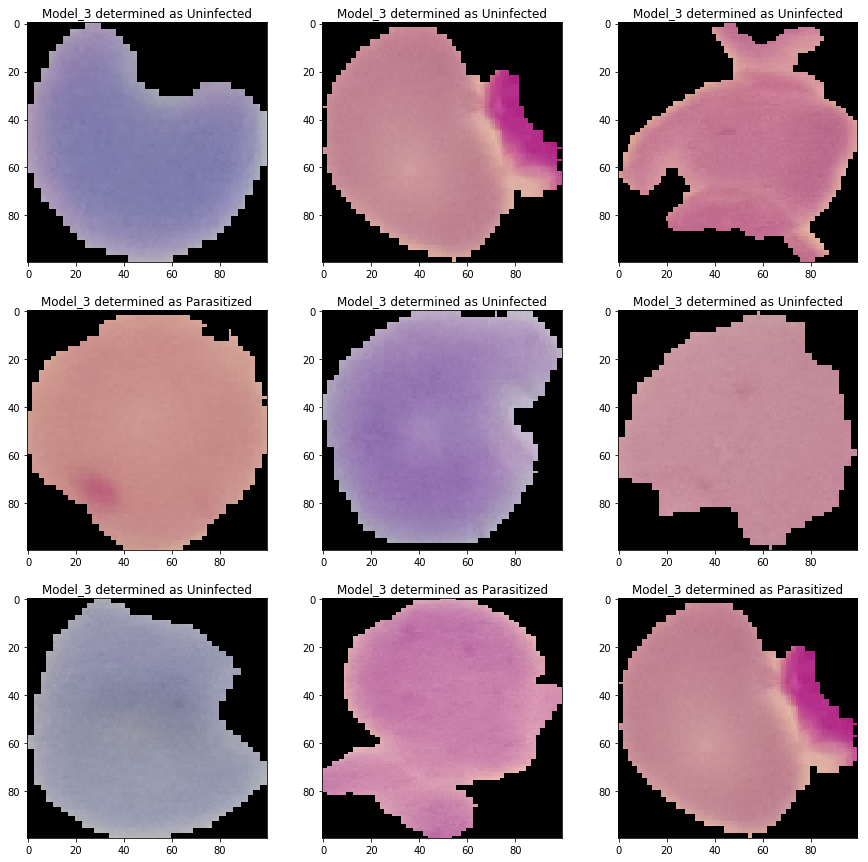

In [50]:
random_number=random.randrange(0,len(w_3))
fig, axs=plt.subplots(3,3,figsize=(15,15))
for ic in range(3):
  for icj in range(3):
    random.seed(random_number+2*icj-ic)
    axs[ic,icj].imshow(x_test[w_3[random.randrange(0,len(w_3))]]);
    axs[ic,icj].set_title(test_3(w_3[random.randrange(0,len(w_3))]));

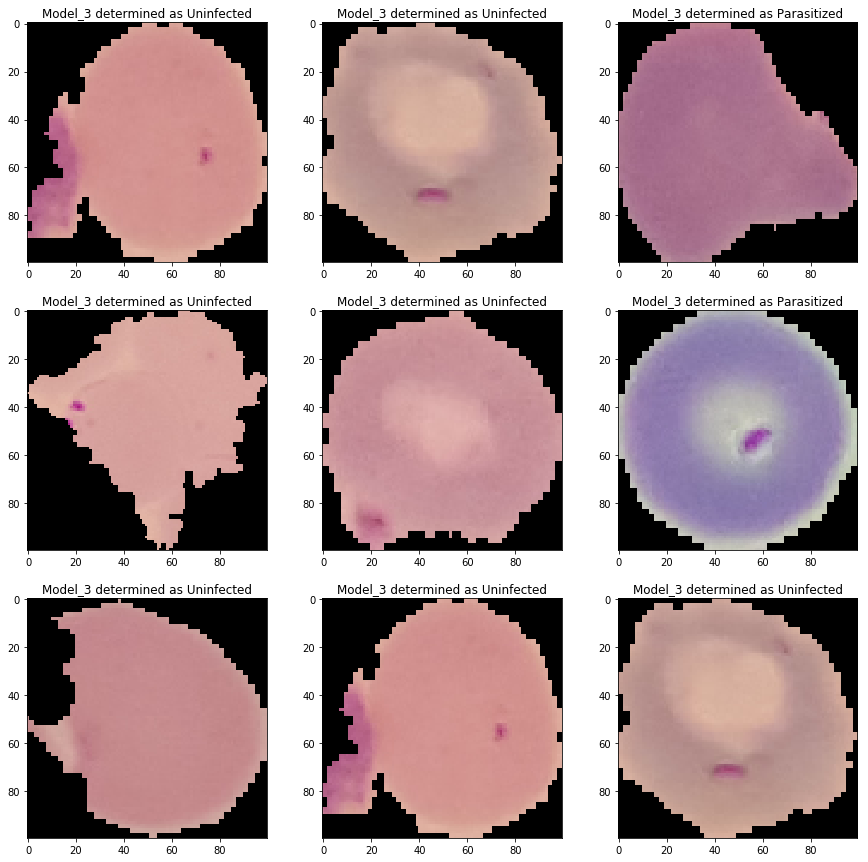

In [76]:
random_number=random.randrange(0,len(w_2))
fig, axs=plt.subplots(3,3,figsize=(15,15))
for ic in range(3):
  for icj in range(3):
    random.seed(random_number+2*icj-ic)
    axs[ic,icj].imshow(x_test[w_3[random.randrange(0,len(w_3))]]);
    axs[ic,icj].set_title(test_3(w_3[random.randrange(0,len(w_3))]));

##Step 3iv: 模型建立 model_4

In [0]:
filter_size=8
filter_num=4

model_4 = Sequential()

model_4.add(Conv2D(filter_num, (filter_size, filter_size), padding='same', input_shape=(img_size, img_size, 3)))
model_4.add(Activation('relu'))
model_4.add(MaxPool2D(pool_size=(2,2)))
#第一次Convolution跟Max-Pooling

model_4.add(Conv2D(filter_num*2, (filter_size, filter_size), padding='same', input_shape=(img_size, img_size, 3)))
model_4.add(Activation('relu'))
model_4.add(MaxPool2D(pool_size=(2,2)))
#第二次Convolution跟Max-Pooling

model_4.add(Conv2D(filter_num*4, (filter_size, filter_size), padding='same', input_shape=(img_size, img_size, 3)))
model_4.add(Activation('relu'))
model_4.add(MaxPool2D(pool_size=(2,2)))
#第三次Convolution跟Max-Pooling

model_4.add(Conv2D(filter_num*8, (filter_size, filter_size), padding='same', input_shape=(img_size, img_size, 3)))
model_4.add(Activation('relu'))
model_4.add(MaxPool2D(pool_size=(2,2)))
#第四次Convolution跟Max-Pooling

model_4.add(Conv2D(filter_num*16, (filter_size, filter_size), padding='same', input_shape=(img_size, img_size, 3)))
model_4.add(Activation('relu'))
model_4.add(MaxPool2D(pool_size=(2,2)))
#第五次Convolution跟Max-Pooling


model_4.add(Flatten())  #用來拉平用的，拉平後才能送入一般的神經網路
model_4.add(Dense(16))
model_4.add(Activation('relu'))
#一般的神經網路

model_4.add(Dense(2))
model_4.add(Activation(tf.nn.softmax))
#輸出層

model_4.compile(loss='mse', optimizer=SGD(lr=0.05), metrics=['accuracy'])

In [52]:
model_4.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 100, 100, 4)       772       
_________________________________________________________________
activation_25 (Activation)   (None, 100, 100, 4)       0         
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 50, 50, 4)         0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 50, 50, 8)         2056      
_________________________________________________________________
activation_26 (Activation)   (None, 50, 50, 8)         0         
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 25, 25, 8)         0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 25, 25, 16)        8208      
__________

In [53]:
model_4.fit(x_train, y_train, batch_size=40, epochs=15)

Epoch 1/15
22046/22046 [==============================] - 6s 270us/step - loss: 0.2417 - acc: 0.5780
Epoch 2/15
22046/22046 [==============================] - 5s 235us/step - loss: 0.1328 - acc: 0.8092
Epoch 3/15
22046/22046 [==============================] - 5s 232us/step - loss: 0.0452 - acc: 0.9434
Epoch 4/15
22046/22046 [==============================] - 5s 234us/step - loss: 0.0385 - acc: 0.9527
Epoch 5/15
22046/22046 [==============================] - 5s 235us/step - loss: 0.0361 - acc: 0.9555
Epoch 6/15
22046/22046 [==============================] - 5s 233us/step - loss: 0.0351 - acc: 0.9573
Epoch 7/15
22046/22046 [==============================] - 5s 234us/step - loss: 0.0339 - acc: 0.9592
Epoch 8/15
22046/22046 [==============================] - 5s 232us/step - loss: 0.0326 - acc: 0.9607
Epoch 9/15
22046/22046 [==============================] - 5s 233us/step - loss: 0.0319 - acc: 0.9613
Epoch 10/15
22046/22046 [==============================] - 5s 232us/step - loss: 0.0307 - a

##Step 4iv: 模型檢討 model_4

In [54]:
score = model_4.evaluate(x_test, y_test)
print("Loss: %f" %score[0])
print("準確率: %f" %(score[1]*100))

5512/5512 [==============================] - 1s 201us/step
Loss: 0.030251
準確率: 96.353411


In [0]:
predict_4 = model_4.predict_classes(x_test)
w_4=[]
for ic in range(3200):
  if (predict_4[ic] == 1) & (y_test[ic][1]==0) :
     w_4.append(ic)
  if (predict_4[ic] == 0) & (y_test[ic][0]==0) :
     w_4.append(ic)
w_4

In [0]:
def test_4(ic):

    if predict_4[ic] == 1:
       return 'Model_4 determined as Parasitized'
    else:
       return 'Model_4 determined as Uninfected'

###到底model_4判斷錯誤了什麼？？

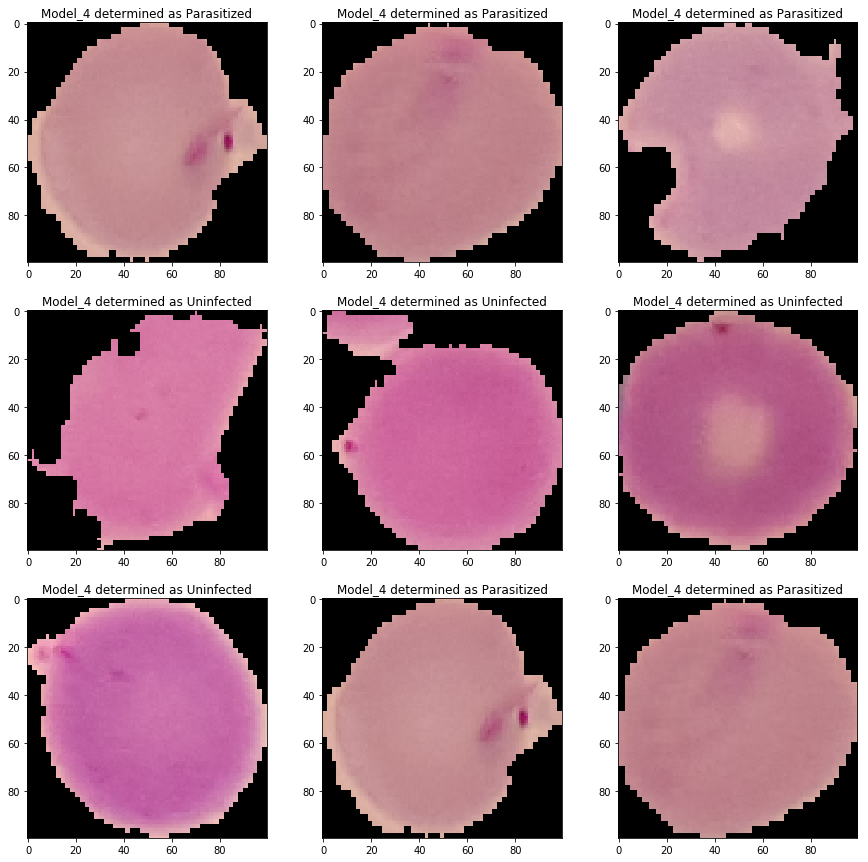

In [66]:
random_number=random.randrange(0,len(w_4))
fig, axs=plt.subplots(3,3,figsize=(15,15))
for ic in range(3):
  for icj in range(3):
    random.seed(random_number+2*icj-ic)
    axs[ic,icj].imshow(x_test[w_4[random.randrange(0,len(w_4))]]);
    axs[ic,icj].set_title(test_4(w_4[random.randrange(0,len(w_4))]));

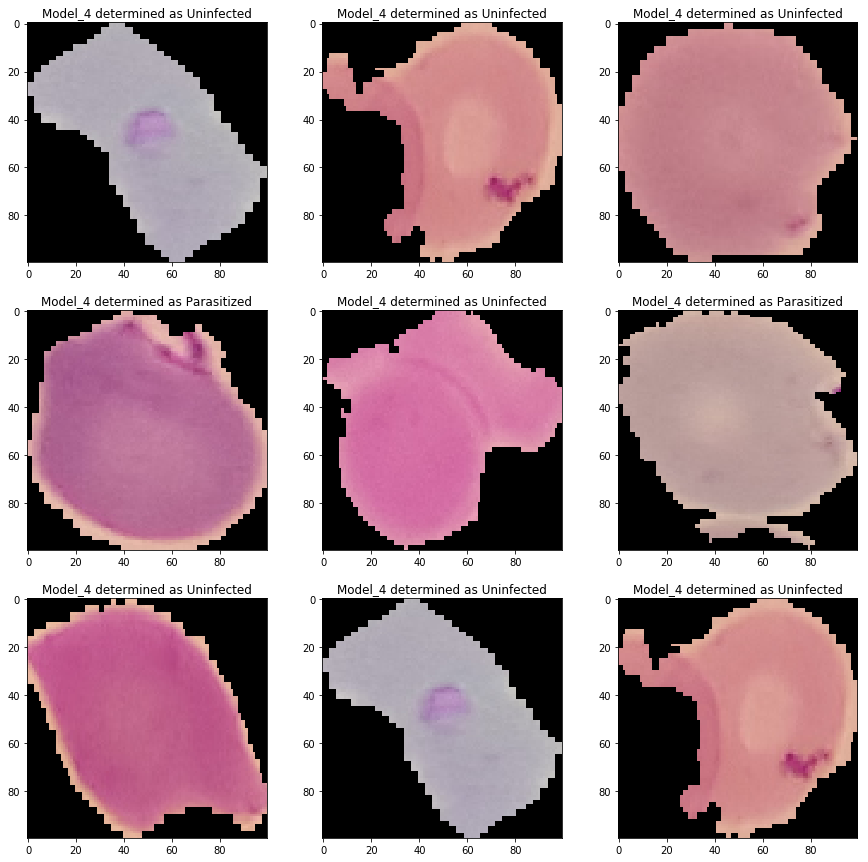

In [65]:
random_number=random.randrange(0,len(w_4))
fig, axs=plt.subplots(3,3,figsize=(15,15))
for ic in range(3):
  for icj in range(3):
    random.seed(random_number+2*icj-ic)
    axs[ic,icj].imshow(x_test[w_4[random.randrange(0,len(w_4))]]);
    axs[ic,icj].set_title(test_4(w_4[random.randrange(0,len(w_4))]));

##Step 5: 4個model檢討

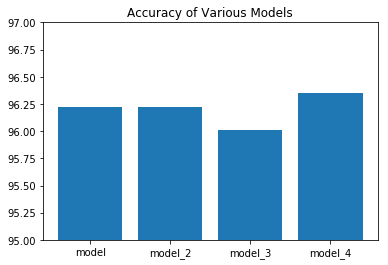

In [84]:
Accuracies=[96.226415,96.226415,96.008708,96.353411]
Models=["model","model_2","model_3","model_4"]
plt.bar(Models,Accuracies)
plt.ylim(95,97)
plt.title('Accuracy of Various Models');

In [0]:
a=np.zeros(len(x_test))
for ic in range(len(w_0)):
  a[w_0[ic]] += 1
for ic in range(len(w_2)):  
  a[w_2[ic]] += 1
for ic in range(len(w_3)):  
  a[w_3[ic]] += 1
for ic in range(len(w_4)):  
  a[w_4[ic]] += 1

In [0]:
fourth=list(np.where(a==4)[0])
third=list(np.where(a==3)[0])
second=list(np.where(a==2)[0])
first=list(np.where(a==1)[0])

In [0]:
def test_5(ic):

    if predict_4[ic] == 1:
       return '4 models determined as Parasitized'
    else:
       return '4 models determined as Uninfected'

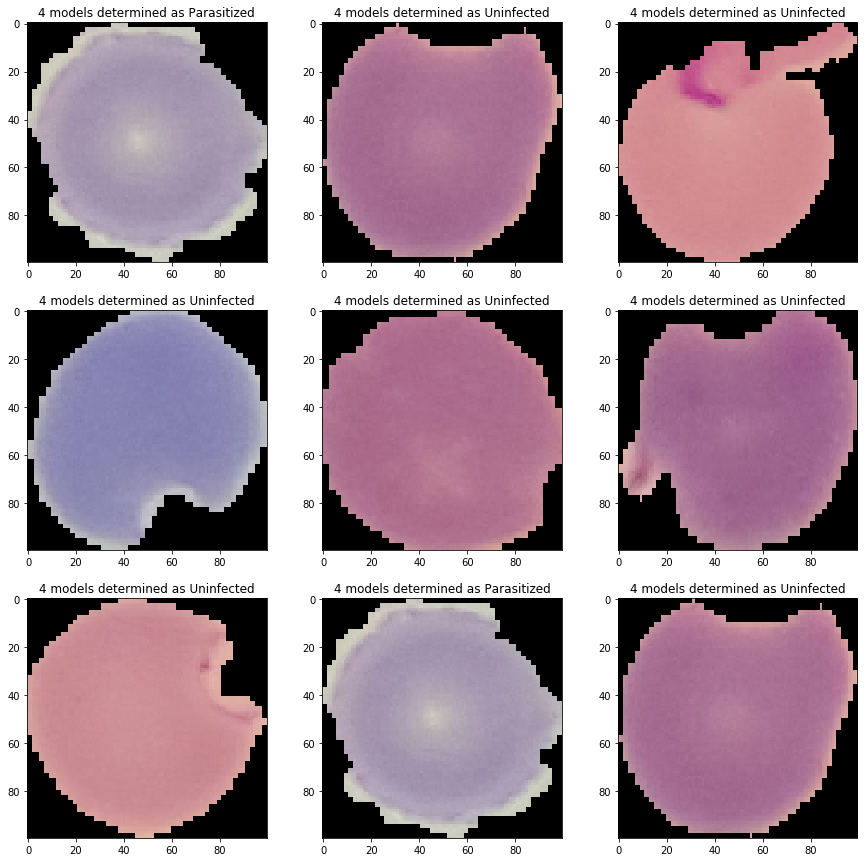

In [78]:
random_number=random.randrange(0,len(fourth))
fig, axs=plt.subplots(3,3,figsize=(15,15))
for ic in range(3):
  for icj in range(3):
    random.seed(random_number+2*icj-ic)
    axs[ic,icj].imshow(x_test[fourth[random.randrange(0,len(fourth))]]);
    axs[ic,icj].set_title(test_5(fourth[random.randrange(0,len(fourth))]));

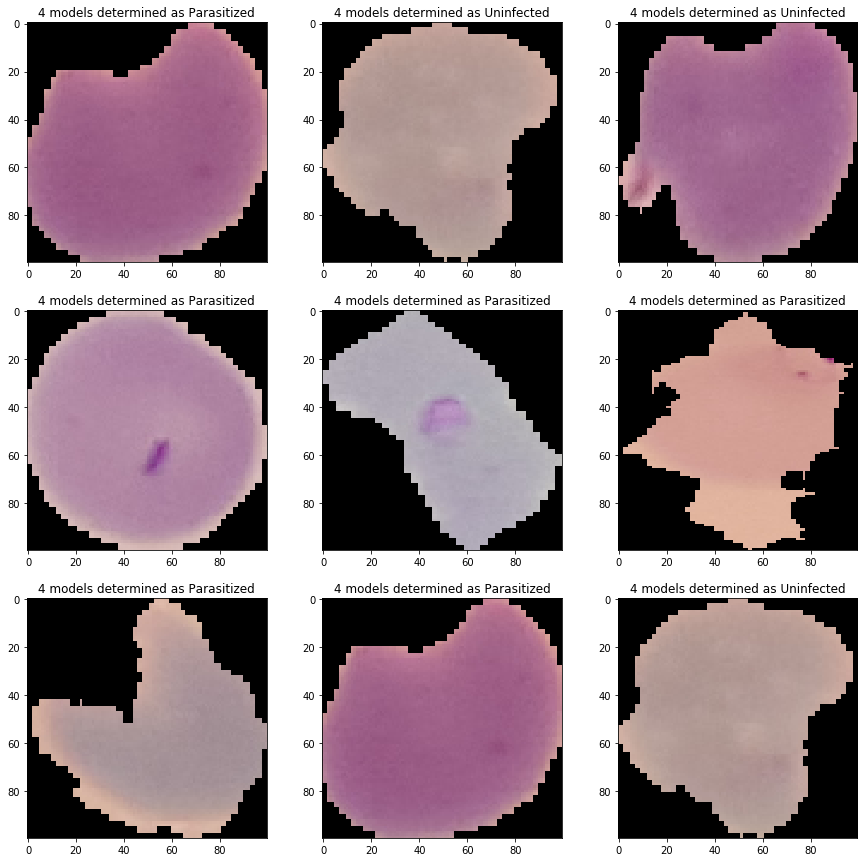

In [79]:
random_number=random.randrange(0,len(fourth))
fig, axs=plt.subplots(3,3,figsize=(15,15))
for ic in range(3):
  for icj in range(3):
    random.seed(random_number+2*icj-ic)
    axs[ic,icj].imshow(x_test[fourth[random.randrange(0,len(fourth))]]);
    axs[ic,icj].set_title(test_5(fourth[random.randrange(0,len(fourth))]));